### Import necessary modules and set graphing defaults

In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_boston, load_diabetes
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# Set Matplotlib default text sizes
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

### - Import and prepare data

In [2]:
# Import Boston housing dataset and transform into pandas df
def sklearn_to_df(sklearn_dataset):
    df = pd.DataFrame(sklearn_dataset.data, columns=sklearn_dataset.feature_names)
    df['target'] = pd.Series(sklearn_dataset.target)
    cols = list(df.columns)
    cols = [cols[-1]] + cols[:-1]
    df = df[cols]
    return df
df_boston = sklearn_to_df(load_boston())
df_boston.rename(columns={"target": "MEDV"}, inplace=True)

# Randomize dataframe 
df_boston = df_boston.sample(frac=1).reset_index(drop=True)

# Filter dataset for prettier graph (yes this is cheating)
df_boston = df_boston[df_boston['MEDV'] < 50]
df_boston = df_boston[df_boston['RM'] > 4.5]

# Sepearate the dataset with a 50 / 50 split
np.random.seed(10)
msk = np.random.rand(len(df_boston)) < 0.05
df_boston_train = df_boston[msk]
df_boston_test = df_boston[~msk]

# Full dataset
X_full = df_boston[['RM']]
X_seq_full = np.linspace(X_full.min(),X_full.max(),300).reshape(-1,1)
y_full = df_boston[['MEDV']]*1000

# Train dataset for training
X_train = df_boston_train[['RM']]
X_seq_train = np.linspace(X_train.min(),X_train.max(),300).reshape(-1,1)
y_train = df_boston_train[['MEDV']]*1000

# Test dataset for testing the trained model
X_test = df_boston_test[['RM']]
X_seq_test = np.linspace(X_test.min(),X_test.max(),300).reshape(-1,1)
y_test = df_boston_test[['MEDV']]*1000

### Overfitting: A Story Based Explanation

Your boss walks up to you on Monday morning and says "Hey I just received a new dataset. It details median Bouston house prices and the average number of rooms. Won't you be a good sport and create a linear regression model to predict house prices based on the number of rooms?"

You respond "Sure sounds great!" Your boss walks off and you bring in the data and experiment first with simple linear regression (y=mx+b) and you receive an R^2 value of 0.6 then you experiment with polynomial regression (y=mx^2+bx+c) and you receive an R^2 value of 0.7. As you keep bumping up the polynomial degree (X^2 -> degree is 2), your R^2 improves like magic (**See Figure 1**). You proudly type out your polynomial regression equation, y = aX^6 + bx^5 ... + c and email it to your boss. With your end of the year review around the corner you are feeling pretttty good. 

Your boss goes on to use the equation to predict house prices in new neighborhoods. After consultation with a local realtor, your boss realizes that your predictions are +- 50K off of reality. He comes storming to your cube and demands an answer. You don't know how to answer him... Until you read through this notebook!

The error was in overfitting. Overfitting happens when you create a model that captures too much variation in the dataset. If you have an extremely complex model that accounts for all outliers it will perform poorly on new data without those same outliers. This happened in the example above. An extremely complex polynomial line was fit to a subset of the data. When applied to new data it performed poorly. See **Figure 2** and **Figure 3** below. 

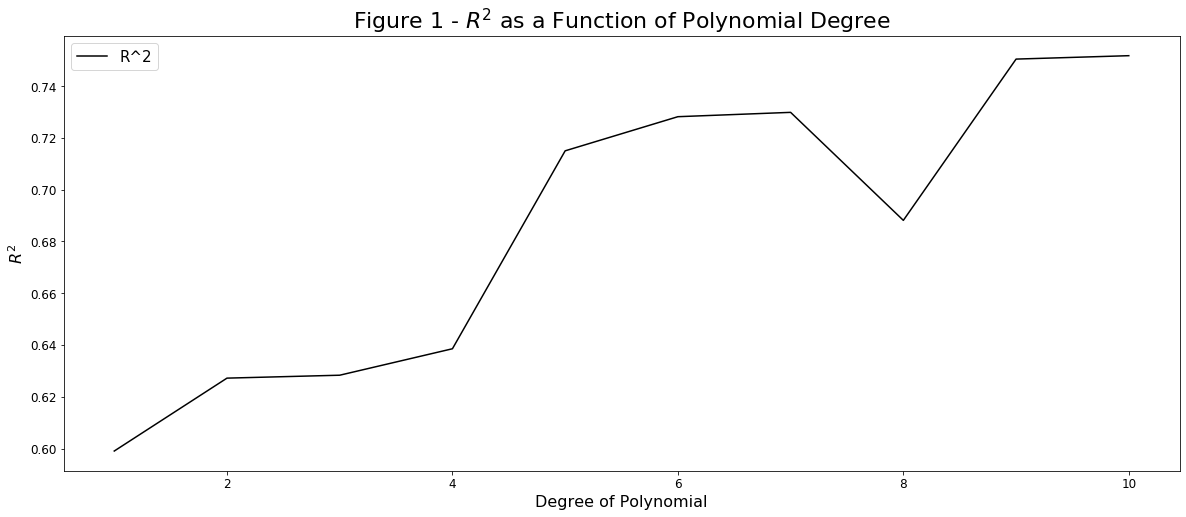

In [3]:
degree_lst = range(1,11)
score_lst = []

for i in degree_lst:
    degree=i
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(X_train,y_train)
    score_lst.append(polyreg.score(X_train,y_train))

score_lst

fig, ax = plt.subplots(figsize=(20,8))
plt.plot(degree_lst, score_lst, color="black", label="R^2")
plt.xlabel('Degree of Polynomial')
plt.ylabel('$R^2$')
plt.title("Figure 1 - $R^2$ as a Function of Polynomial Degree") 
plt.legend(loc=2, prop={'size': 15})
plt.show()


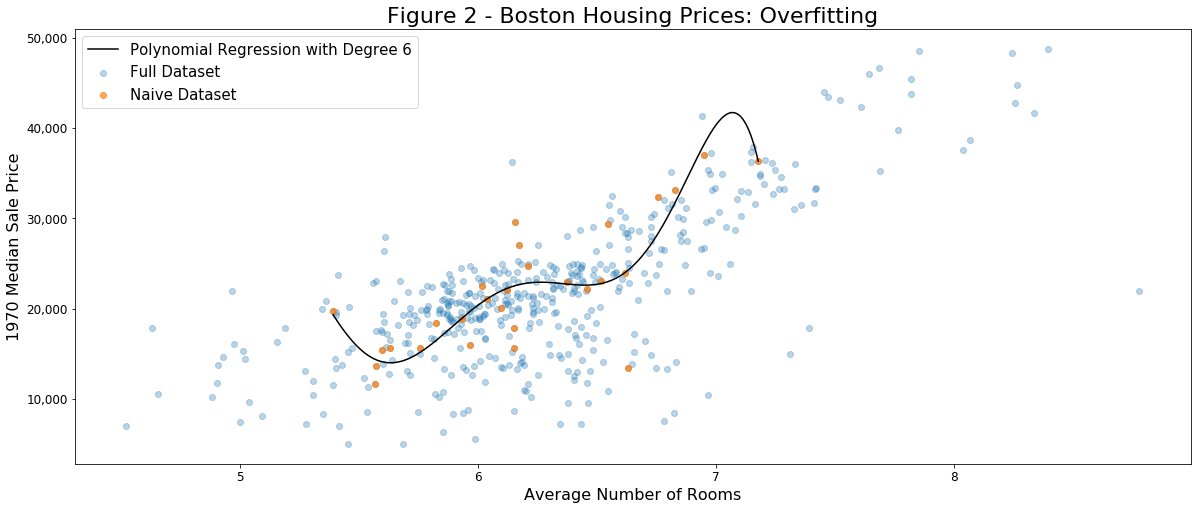

In [4]:
# Create polynomial regression using Scikit Learn
# https://towardsdatascience.com/polynomial-regression-with-scikit-learn-what-you-should-know-bed9d3296f2

# Naive Approach
degree=6
polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
polyreg.fit(X_train,y_train)

fig, ax = plt.subplots(figsize=(20,8))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.scatter(X_full,y_full, label="Full Dataset", alpha=0.3)
plt.scatter(X_train,y_train, label="Naive Dataset", alpha=0.7)
plt.plot(X_seq_train,polyreg.predict(X_seq_train),color="black", label="Polynomial Regression with Degree "+str(degree))
plt.xlabel('Average Number of Rooms')
plt.ylabel('1970 Median Sale Price')
plt.title("Figure 2 - Boston Housing Prices: Overfitting") 
plt.legend(loc=2, prop={'size': 15})
plt.show()



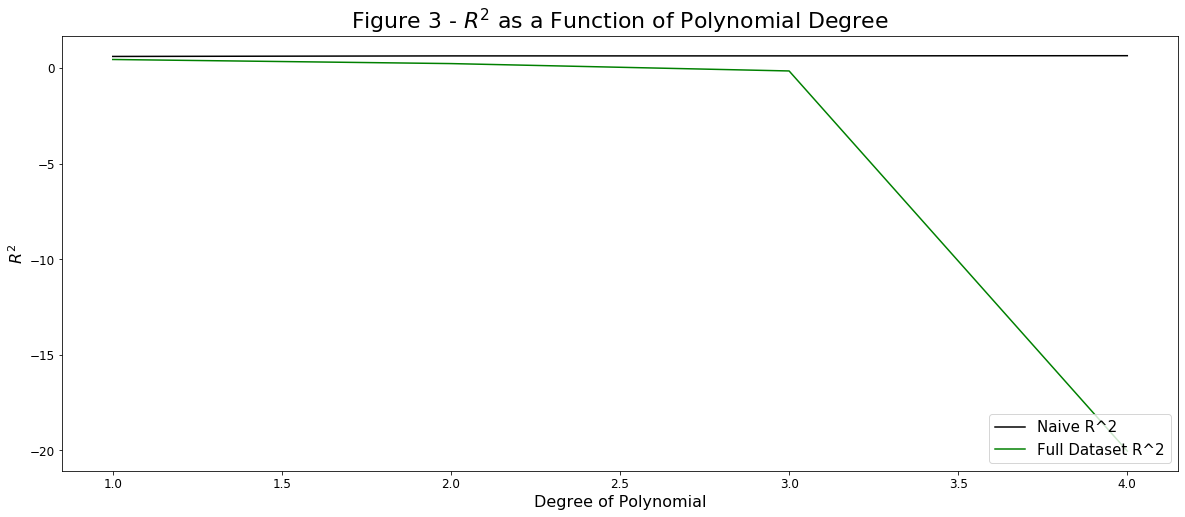

In [5]:
degree_lst = range(1,5)
train_score_lst = []
test_score_lst = []

for i in degree_lst:
    degree=i
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    polyreg.fit(X_train,y_train)
    train_score_lst.append(polyreg.score(X_train, y_train))
    test_score_lst.append(polyreg.score(X_full, y_full))

score_lst

fig, ax = plt.subplots(figsize=(20,8))
plt.plot(degree_lst, train_score_lst, color="black", label="Naive R^2")
plt.plot(degree_lst, test_score_lst, color="green", label="Full Dataset R^2")
plt.xlabel('Degree of Polynomial')
plt.ylabel('$R^2$')
plt.title("Figure 3 - $R^2$ as a Function of Polynomial Degree") 
plt.legend(loc='lower right', prop={'size': 15})
plt.show()


### So what is the solution... Cross Validation!
Lets say that you get 100 data points. The naive approach is to train your model on all 100 points and to hope for the best when your model performs in the wild. The Pro approach is to use cross validation:
    - You recieve 100 data points
    - You take 3/4ths of those data points to train your model and 1/4 of those points to score the model
    - You take a different 3/4ths of those data points to train your model and a different 1/4 of those points to score the model
    - You repeat this process until you have exhausted all 3/4 & 1/4 unique combinations
    
What I described above would be called 4-fold cross validation. You can have 2-fold (1/2 & 1/2) or 3-fold (2/3 & 1/3) or 10-fold (9/10 & 1/10)...

This concept is best described with an image from...

Qiubing Ren, Mingchao Li & Shuai Han (2019): Tectonic discrimination ofolivine in basalt using data mining techniques based on major elements: a comparative study frommultiple perspectives, Big Earth Data, DOI: 10.1080/20964471.2019.1572452

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.researchgate.net/profile/Mingchao_Li/publication/331209203/figure/fig2/AS:728070977748994@1550597056956/K-fold-cross-validation-method.png")

### Explicit K-Fold Method
For demonstration purposes... Unlikely you will actually use this

In [7]:
from sklearn.model_selection import KFold
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 1, 2])
cv = KFold(n_splits=4)

for train_index, test_index in cv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [1 2 3] TEST: [0]
TRAIN: [0 2 3] TEST: [1]
TRAIN: [0 1 3] TEST: [2]
TRAIN: [0 1 2] TEST: [3]


### Train, Test, Split Method
Simplified method. Basically equivalent to the hold out cross validation method

In [8]:
from sklearn.model_selection import train_test_split

# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.4, random_state=42)

# Create model instance, train model, test model
lm = LinearRegression()
model = lm.fit(X_train, y_train)
lm.score(X_test, y_test)


0.5070733121614832

### K-Fold Cross Validation

In [9]:
# Necessary imports: 
from sklearn.model_selection import cross_val_score

# Create model instance
lm = LinearRegression()

# Perform Cross-Validation
scores = cross_val_score(lm, X_full, y_full, cv=6)
print("Cross-validated scores:", scores)
print("Cross-validated score Average:", round(scores.mean(),2))

Cross-validated scores: [0.46205814 0.56236573 0.65653717 0.57695559 0.24934676 0.44489381]
Cross-validated score Average: 0.49


### Additional notebook that goes through practicalities of Cross Validation and Train Test Split

https://github.com/TannerGilbert/Tutorials/blob/master/Scikit-Learn-Tutorial/10.%20Cross%20Validation%20and%20Model%20Selection.ipynb

### Additional Types of Cross-Validation

We already examined k-fold cross-validation. Additionally there is:
    - Stratified k-fold cross validation
    - Hold-out based validation
    - Leave-one-out cross validation
    - Group k-fold cross validation    

#### Stratified k-fold cross validation
This method is appropriate for imbalanced datasets like cancer detection or credit card fraud. For 99% of transactions you do not have credit card fraud. By using stratified k-fold cross validation you ensure that all of your folds of data have the same ratio of fraud and non-fraud (1% and 99%). Without taking this precaution you might end up with many folds that contain no fraud.

#### Hold-out based validation
This method is appropriate for very large datasets or for time series data. If you have 10 million data points it would be computationally expensive to train and test your model multiple times on so many data points. With so much data, 'holding out' 10% of the data for one-time testing is satisfactory. This method is also preferred if you want to test a time series prediction on a subset of continuous time.

#### Leave-one-out cross validation
This method is appropriate for VERY small datasets. If you have 10 data points then you would have 10-folds. In effect you would be testing on one 'left-out' data point each iteration

#### Group k-fold cross validation
  This method is appropriate if you want to ensure no grouping can be found in two folds.
  